# 호텔 예약 취소에서 인과적인 요소 파악하기
- 호텔 예약 취소의 원인이 되는 요소를 찾고 싶다.
- 그런데 이를 RCT로 하기는 현실적으로 어렵다.
- observable data를 통해서 그 원인을 찾아보자.

In [115]:
import dowhy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [116]:
dataset = pd.read_csv('https://raw.githubusercontent.com/Sid-darthvader/DoWhy-The-Causal-Story-Behind-Hotel-Booking-Cancellations/master/hotel_bookings.csv')
dataset.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [117]:
dataset.shape

In [118]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [119]:
dataset.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date'],
      dtype='object')

## FE

In [120]:
# Total stay in nights
dataset['total_stay'] = dataset['stays_in_week_nights'] + dataset['stays_in_weekend_nights']

# Total number of guests
dataset['guests'] = dataset['adults'] + dataset['children'] + dataset['babies']

# Creating the different_room_assigned feature
dataset['different_room_assigned'] = 0
slice_indices = dataset['reserved_room_type'] != dataset['assigned_room_type']
dataset.loc[slice_indices, 'different_room_assigned'] = 1

# Deleting older features
dataset = dataset.drop(
    [
    'stays_in_week_nights','stays_in_weekend_nights',
    'adults','children','babies',
    'reserved_room_type','assigned_room_type'
    ],
    axis=1
)


In [121]:
dataset.isnull().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
booking_changes                        0
deposit_type                           0
agent                              16340
company                           112593
days_in_waiting_list                   0
customer_type                          0
adr                                    0
required_car_parking_spaces            0
total_of_special_requests              0
reservation_status                     0
reservation_stat

In [122]:
# null값이 많아서
dataset = dataset.drop(['agent','company'],axis=1)

In [123]:
# Replacing missing countries with most freqently occuring countries
dataset['country']= dataset['country'].fillna(dataset['country'].mode()[0])

# 그외 필요없는 컬럼 삭제
dataset = dataset.drop(['reservation_status','reservation_status_date','arrival_date_day_of_month'], axis=1)
dataset = dataset.drop(['arrival_date_year'], axis=1)
dataset = dataset.drop(['distribution_channel'], axis=1)

- `different_room_assigned`: treatment
- `is_canceled`: outcome

In [124]:
# Replacing 1 by True and 0 by False for the experiment and outcome variables

dataset['different_room_assigned'] = dataset['different_room_assigned'].replace(1, True)
dataset['different_room_assigned'] = dataset['different_room_assigned'].replace(0, False)
dataset['is_canceled'] = dataset['is_canceled'].replace(1, True)
dataset['is_canceled'] = dataset['is_canceled'].replace(0, False)

In [125]:
dataset.dropna(inplace=True)

In [126]:
print(dataset.shape)
print(dataset.columns)
dataset.iloc[:, 5:20].head()

(119386, 21)
Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_month',
       'arrival_date_week_number', 'meal', 'country', 'market_segment',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes', 'deposit_type',
       'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'total_stay', 'guests', 'different_room_assigned'],
      dtype='object')


,meal,country,market_segment,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,total_stay,guests
0,BB,PRT,Direct,0,0,0,3,No Deposit,0,Transient,0.0,0,0,0,2.0
1,BB,PRT,Direct,0,0,0,4,No Deposit,0,Transient,0.0,0,0,0,2.0
2,BB,GBR,Direct,0,0,0,0,No Deposit,0,Transient,75.0,0,0,1,1.0
3,BB,GBR,Corporate,0,0,0,0,No Deposit,0,Transient,75.0,0,0,1,1.0
4,BB,GBR,Online TA,0,0,0,0,No Deposit,0,Transient,98.0,0,1,2,2.0


- `deposit`: 보증금

In [127]:
dataset = dataset[dataset.deposit_type == "No Deposit"]
dataset.groupby(['is_canceled'])['hotel'].count()

is_canceled
False    74947
True     29690
Name: hotel, dtype: int64

In [128]:
dataset.groupby(['different_room_assigned'])['hotel'].count()

different_room_assigned
False    89844
True     14793
Name: hotel, dtype: int64

## step1. Create a Causal Graph

- domain knowledge를 최대한 이용하여 영향을 주고 받는 변수들의 관계를 파악해보자.
- 완벽하지 않더라도 최대한 정보를 이용하는 것이 좋다. 
- `different_room_assigned`와 `is_canceled` 모두 영향을 주는 confounder는 일단 `booking_changes`이 있고 unobserved counfounder가 또 존재한다.

In [129]:
import pygraphviz

In [130]:
# 변수명[label = 그림에 표기될 이름]
# 변수명(label 없으면 변수명 그대로 그림에 표기됨)
# U = Unobserved confounder
# 변수명 -> 변수명 : 영향을 주는 관계
# 변수명 -> {변수명, 변수명} : 다수에 영향을 주는 변수 관계

causal_graph = """digraph {
    different_room_assigned[label="Different Room Assigned"];
    is_canceled[label="Booking Cancelled"];
    booking_changes[label="Booking Changes"];
    previous_bookings_not_canceled[label="Previous Booking Retentions"];
    days_in_waiting_list[label="Days in Waitlist"];
    lead_time[label="Lead Time"];
    market_segment[label="Market Segment"];
    country[label="Country"];
    U[label="Unobserved Confounders"];
    
    is_repeated_guest;
    total_stay;
    guests;
    meal;
    hotel;
    
    U->different_room_assigned; 
    U->is_canceled;
    U->required_car_parking_spaces;
    
    market_segment -> lead_time;
    lead_time -> is_canceled; 
    country -> lead_time;
    different_room_assigned -> is_canceled;
    country -> meal;
    lead_time -> days_in_waiting_list;
    days_in_waiting_list -> is_canceled;
    previous_bookings_not_canceled -> is_canceled;
    previous_bookings_not_canceled -> is_repeated_guest;
    is_repeated_guest -> is_canceled;
    total_stay -> is_canceled;
    guests -> is_canceled;
    booking_changes -> different_room_assigned; 
    booking_changes -> is_canceled; 
    hotel -> is_canceled;
    required_car_parking_spaces -> is_canceled;
    total_of_special_requests -> is_canceled;
    
    country -> {hotel, required_car_parking_spaces,total_of_special_requests,is_canceled};
    market_segment -> {hotel, required_car_parking_spaces,total_of_special_requests,is_canceled};
    }"""

In [140]:
model= dowhy.CausalModel(
        data = dataset,
        graph = causal_graph.replace("\n", " "), # causal_graph 라는 문자열에서 띄어쓰기를 space로 대체해주는 역할
        treatment = 'different_room_assigned',
        outcome = 'is_canceled') 
model.view_model(file_name='booking_causal_model')

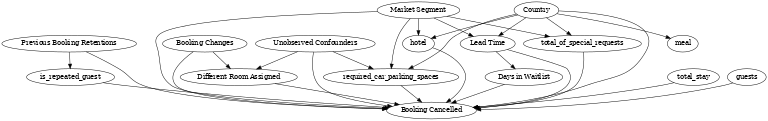

In [141]:
from IPython.display import Image, display
display(Image(filename = "booking_causal_model.png"))

## step2. Identify Causal Effect

In [133]:
import statsmodels

- Causal Estimand $\xrightarrow{Identification}$ Statistical Estimand $\xrightarrow{Estimation}$ Estimate 

In [134]:
# Identify the causal effect
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
No such variable(s) found!

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



## step3. Estimate Identified Estimand

In [135]:
estimate = model.estimate_effect(identified_estimand, 
                                 method_name="backdoor.propensity_score_stratification", target_units="ate")

print(estimate)

propensity_score_stratification
Estimation failed! No relevant identified estimand available for this estimation method.


## step4. Refute results

- Add Random Common Cause
    - 랜덤한 독립 변수를 common cause로 추가해본다.
    - 인과추론시 과정이 옳았다면 추정한 값이 크게 변해서는 안된다.

In [136]:
# refute1_results = model.refute_estimate(identified_estimand, estimate,
#         method_name = "random_common_cause")

- Placebo Treatment Refuter
    - treatment를 랜덤한 독립변수로 대체한다면 추정된 인과효과는 0에 가까워져야 한다.

In [137]:
# refute2_results=model.refute_estimate(identified_estimand, estimate,
#         method_name="placebo_treatment_refuter")

- Data Subset Refuter
    - dataset의 일부를 랜덤하게 대체해도 robust한 결과가 나와야한다.
    - subset들을 랜덤하게 넣어보고 통계적으로 유의하에 estimated effect가 다른지 확인한다.

In [138]:
# refute3_results=model.refute_estimate(identified_estimand, estimate,
#         method_name="data_subset_refuter")